In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from src.utils import evaluate_model_d

RND = 42

path = Path(r'C:\Python\projects\CGPAPrediction\data\final_grade_prediction_dataset')

In [2]:
train_df, val_df, test_df = pd.read_csv(path / 'train.csv'), pd.read_csv(path / 'val.csv'), pd.read_csv(
    path / 'test.csv')

In [3]:
data = {'train': train_df, 'val': val_df, 'test': test_df}

In [4]:
# preprocessing for classic models
mean_col_names = ['Mean 0', 'Mean 1', 'Mean 2', 'Mean 3']


def calc_means(df):
    last_semester_mask = df['Semester'] == 4
    x_df = df[last_semester_mask].copy()
    other_semesters = df[~last_semester_mask]
    x_df[mean_col_names] = None
    for ids, st_other in other_semesters.groupby('Student ID'):
        st_mask = x_df['Student ID'] == ids
        for sem_n, sem_df in st_other.groupby('Semester'):
            x_df.loc[st_mask, mean_col_names[sem_n]] = sem_df['Final Grade'].mean()
    return x_df

def grade_to_cat(g):
    if g < 70:
        return 0
    elif g < 90:
        return 1
    else:
        return 2

def to_one_hot(arr: np.array, max_size):
    res = np.zeros((arr.size, max_size), dtype='float32')
    res[np.arange(arr.size), arr] = 1.0
    return res

def df_features_to_np(df, inputs_description, one_hot_dims):
    arrays = []
    for col, col_type in inputs_description.items():
        if col_type == 'one-hot':
            arrays.append(to_one_hot(df[col].values, one_hot_dims[col]))
        else:
            arrays.append(df[col].values.reshape(-1, 1))
    return np.concatenate(arrays, axis=1)

In [5]:
for k, df in data.items():
    data[k] = calc_means(df)

In [7]:
data_y = {}
for k, df in data.items():
    data_y[k] = data[k]['Final Grade'].map(grade_to_cat).values
    data[k] = data[k].drop('Final Grade', axis=1)

In [8]:
inputs_description = {'Educational Program / Major': 'one-hot', 'Payment Type': 'one-hot',
                      'Funding Type': 'one-hot', 'Language of Instruction': 'one-hot',
                      'Institute': 'one-hot', 'Study Mode': 'one-hot',
                      'Student Gender': 'one-hot', 'Instructor Gender': 'one-hot',
                      'Midterm 1': 'number', 'Midterm 2': 'number', 'Rating': 'number', 'Mean 0': 'number',
                      'Mean 1': 'number', 'Mean 2': 'number', 'Mean 3': 'number'}

In [9]:
all_data = pd.concat([train_df, val_df, test_df], ignore_index=True)
one_hot_dims = {k: len(all_data[k].unique()) for k, v in inputs_description.items() if v == 'one-hot'}

In [12]:
data_x = {}
for k, df in data.items():
    data_x[k] = df_features_to_np(df, inputs_description, one_hot_dims)

In [13]:
for k, df in data.items():
    data[k] = df[list(inputs_description.keys())]

In [14]:
data['test']

,Educational Program / Major,Payment Type,Funding Type,Language of Instruction,Institute,Study Mode,Student Gender,Instructor Gender,Midterm 1,Midterm 2,Rating,Mean 0,Mean 1,Mean 2,Mean 3
9380,18,1,1,1,0,0,0,0,89.0,90,94,89.714286,90.428571,82.5,89.0
9381,18,1,1,1,0,0,0,0,90.0,80,84,89.714286,90.428571,82.5,89.0
9382,18,1,1,1,0,0,0,0,90.0,80,90,89.714286,90.428571,82.5,89.0
9383,18,1,1,1,0,0,0,0,75.0,75,77,89.714286,90.428571,82.5,89.0
9384,18,1,1,1,0,0,0,0,87.0,85,86,89.714286,90.428571,82.5,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11587,27,1,1,0,2,0,1,1,70.0,70,70,83.857143,84.5,83.166667,80.833333
11588,27,1,1,0,2,0,1,0,70.0,75,68,83.857143,84.5,83.166667,80.833333
11589,27,1,1,0,2,0,1,1,55.0,85,70,83.857143,84.5,83.166667,80.833333
11590,27,1,1,0,2,0,1,0,42.0,65,52,83.857143,84.5,83.166667,80.833333


In [15]:
data_x['test']

array([[0.0, 0.0, 0.0, ..., np.float64(90.42857142857143),
        np.float64(82.5), np.float64(89.0)],
       [0.0, 0.0, 0.0, ..., np.float64(90.42857142857143),
        np.float64(82.5), np.float64(89.0)],
       [0.0, 0.0, 0.0, ..., np.float64(90.42857142857143),
        np.float64(82.5), np.float64(89.0)],
       ...,
       [0.0, 0.0, 0.0, ..., np.float64(84.5),
        np.float64(83.16666666666667), np.float64(80.83333333333333)],
       [0.0, 0.0, 0.0, ..., np.float64(84.5),
        np.float64(83.16666666666667), np.float64(80.83333333333333)],
       [0.0, 0.0, 0.0, ..., np.float64(84.5),
        np.float64(83.16666666666667), np.float64(80.83333333333333)]],
      shape=(2212, 102), dtype=object)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib

RND = 42



param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 40],
    'min_samples_leaf': [1, 2, 5]
}
base = RandomForestClassifier(n_jobs=200, random_state=RND, class_weight='balanced')
gs = GridSearchCV(base, param_grid, cv=3, scoring='f1_weighted', n_jobs=200, verbose=1)
gs.fit(data_x['val'], data_y['val'])
gs_forest_model = gs.best_estimator_

gs_forest_model.fit(data_x['train'], data_y['train'])





# def feature_importances_df(model, feature_names, topn=50):
#     df = pd.DataFrame({
#         'feature': feature_names,
#         'importance': model.feature_importances_
#     }).sort_values('importance', ascending=False).reset_index(drop=True)
#     return df.head(topn)

#
# def save_model(model, path):
#     joblib.dump(model, path)

In [ ]:
def evaluate_model(model, X, y, name='data'):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    print(f"\n{name.upper()} | acc={acc:.4f} | f1w={f1:.4f}")
    print(classification_report(y, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    return {'accuracy': acc, 'f1_weighted': f1}

In [ ]:
y_pred = gs_forest_model.predict(data_x['test'])
evaluate_model_d(data_y['test'], y_pred)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def train_classic_models(data_x, data_y):
    X_train, y_train = data_x['train'], data_y['train']

    models = {
        'LogReg': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                max_iter=1000,
                multi_class='multinomial',
                C=2.0,
                solver='lbfgs',
                n_jobs=-1
            ))
        ]),

        'SVM-RBF': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(
                kernel='rbf',
                C=3.0,
                gamma='scale',
                probability=True,
                class_weight='balanced',
                cache_size=500
            ))
        ]),

        'kNN': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', KNeighborsClassifier(
                n_neighbors=15,
                weights='distance',
                p=2,
                n_jobs=-1
            ))
        ]),

        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=4,
            max_features='sqrt',
            n_jobs=-1,
            random_state=42
        ),


        'GradBoost': GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9,
            min_samples_split=3,
            random_state=42
        )
    }

    trained_models = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model

        train_acc = model.score(X_train, y_train)
        test_acc = model.score(data_x['test'], data_y['test'])
        print(f"{name}: train acc = {train_acc:.3f}, val acc = {test_acc:.3f}\n")

    return trained_models

In [20]:
all_models = train_classic_models(data_x, data_y)

Training LogReg...


C:\Python\projects\CGPAPrediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg: train acc = 0.910, val acc = 0.874

Training SVM-RBF...
SVM-RBF: train acc = 0.915, val acc = 0.862

Training kNN...
kNN: train acc = 0.999, val acc = 0.788

Training ExtraTrees...
ExtraTrees: train acc = 0.997, val acc = 0.882

Training GradBoost...
GradBoost: train acc = 0.936, val acc = 0.868



In [21]:
from src.models import GradePredictionModel
import torch
from src.dataset_loader import get_np_dataset

model_path = r'C:\Python\projects\CGPAPrediction\outputs\models\model_weights.pth'
t_data_x, t_data_y, _, _ = get_np_dataset(25, path)

In [72]:
params = {
    'lstm_hidden': 64,
    'attn_hidden': 64,
    'l1': 64,
    'l2': 32,
    'num_classes': 3,
    'dropout': 0.0,
    'num_lstm_layers': 2,
}

inputs_description = {'Educational Program / Major': ('embedding', (58, 7)),
 'Payment Type': ('one-hot', 2),
 'Funding Type': ('one-hot', 9),
 'Language of Instruction': ('one-hot', 2),
 'Institute': ('one-hot', 13),
 'Study Mode': ('one-hot', 7),
 'Course': ('embedding', (502, 22)),
 'Instructor Full Name': ('embedding', (443, 21)),
 'Instructor Department': ('embedding', (73, 8)),
 'Student Gender': ('one-hot', 2),
 'Instructor Gender': ('one-hot', 2),
 'Rating': ('number',),
 'Midterm 1': ('number',),
 'Midterm 2': ('number',)}

model = GradePredictionModel(inputs_description, params)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

C:\Users\Михаил\AppData\Local\Temp\ipykernel_23136\2012740153.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


OptimizedGradePredictionModel(
  (educational_programme_emb_l): Embedding(58, 7)
  (course_emb_l): Embedding(502, 22)
  (instructor_name_emb_l): Embedding(443, 21)
  (instructor_department_emb_l): Embedding(73, 8)
  (attn): OptimizedConditionalAttentionPooling(
    (query_proj): Linear(in_features=98, out_features=64, bias=False)
    (key_proj): Linear(in_features=99, out_features=64, bias=False)
    (value_proj): Linear(in_features=99, out_features=64, bias=False)
  )
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=162, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [23]:
preds = model(**t_data_x['test']).argmax(dim=1)

In [24]:
evaluate_model_d(t_data_y['test'], preds)

{'Accuracy': 0.891500904159132,
 'Precision': 0.8918543312015097,
 'Recall': 0.891500904159132,
 'F1-score': 0.8824781427609185,
 'F1-score (weighted)': 0.8915505769219597}

In [39]:
from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score)

def evaluate_model_n(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    prec_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    rec_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score (macro)': f1, 'F1-score (weighted)': f1_weighted}

In [53]:
test_metrics = {}

In [54]:
test_metrics['Attention-LSTM'] = evaluate_model_n(t_data_y['test'], preds)

In [55]:
for k, v in all_models.items():
    test_metrics[k] = evaluate_model_n(data_y['test'], v.predict(data_x['test']))

In [56]:
test_metrics['RandomForest'] = evaluate_model_n(data_y['test'], gs_forest_model.predict(data_x['test']))

In [60]:
test_metrics['Attention-LSTM']['Accuracy']

89.1500904159132

In [57]:
def val_to_p(d):
    for k, v in d.items():
        d[k] = v*100
    return d
test_metrics_pc = {k: val_to_p(v) for k, v in test_metrics.items()}

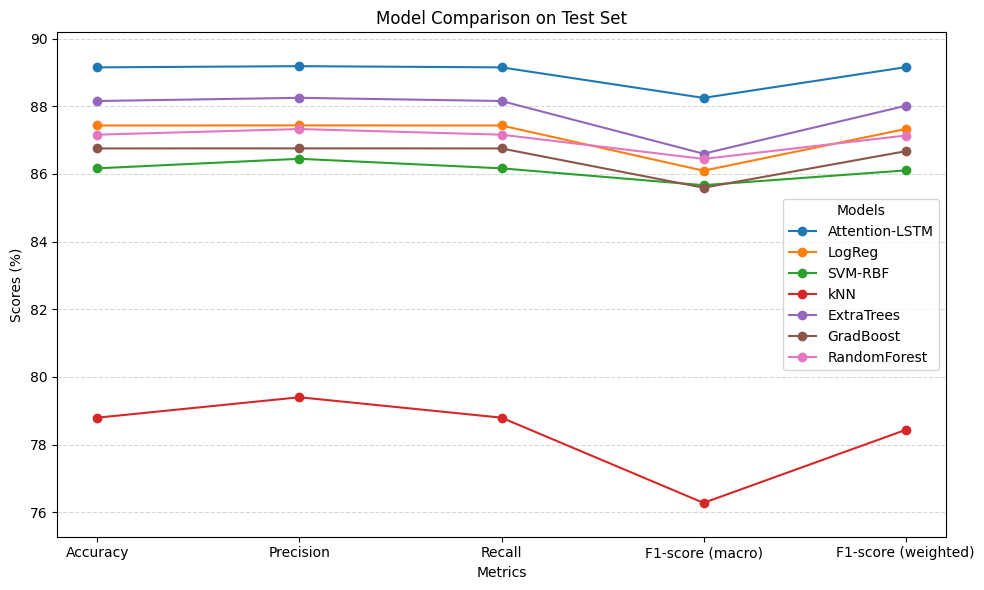

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
pic_path = r'C:\Python\projects\CGPAPrediction\outputs\pics\metrics.png'


df = pd.DataFrame(test_metrics).T

plt.figure(figsize=(10, 6))

for model in df.index:
    plt.plot(df.columns, df.loc[model], marker='o', label=model)

plt.title("Model Comparison on Test Set")
plt.xlabel("Metrics")
plt.ylabel("Scores (%)")

y_min = df.min().min() - 1
y_max = df.max().max() + 1
plt.ylim(y_min, y_max)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Models")
plt.tight_layout()

plt.savefig(pic_path, dpi=300)
plt.show()

ExtraTrees:
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       328
           1       0.87      0.89      0.88      1084
           2       0.88      0.94      0.91       800

    accuracy                           0.88      2212
   macro avg       0.89      0.85      0.87      2212
weighted avg       0.88      0.88      0.88      2212



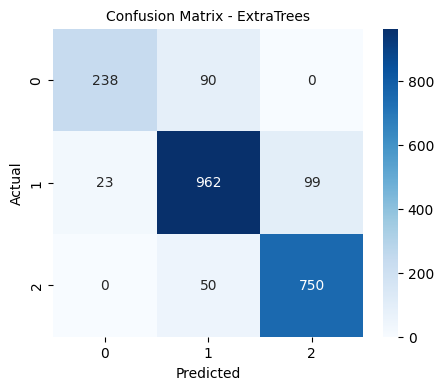

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

yp = all_models['ExtraTrees'].predict(data_x['test'])
print('ExtraTrees:')
print("Classification Report:\n")
print(classification_report(data_y['test'], yp))

cm = confusion_matrix(data_y['test'], yp)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title("Confusion Matrix - ExtraTrees", fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Attention-LSTM:
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       328
           1       0.88      0.90      0.89      1084
           2       0.92      0.90      0.91       800

    accuracy                           0.89      2212
   macro avg       0.89      0.88      0.88      2212
weighted avg       0.89      0.89      0.89      2212



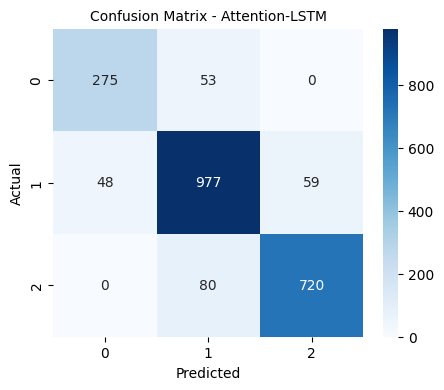

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

yp = model(**t_data_x['test']).argmax(dim=1)
print('Attention-LSTM:')
print("Classification Report:\n")
print(classification_report(t_data_y['test'], yp))

cm = confusion_matrix(data_y['test'], yp)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title("Confusion Matrix - Attention-LSTM", fontsize=10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()